# Projet spécialité Data-IA

Uncomment if you use Drive

In [ ]:
# from google.colab import drive
# drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


# Analyse de données : l'évolution et la prévision de la production automobile dans le monde

Ce projet a pour but d'analyser l'évolution et les tendances de ces dernières années en matière de production/vente automobile, dans le monde.

Nous allons tout d'abord analyser la production mondiale, puis par continent. Pour ensuite s'interesser à plusieurs pays choisis.

En corrélation avec cette analyse, nous devrons également analyser l'évolution de la population. Car c'est celle-ci qui determinera les facteurs de production/ventes.

Dans une façon de penser plus "vert", nous pouvons réduire la pollution mondiale en adaptant la production de véhicules afin de limiter la surproduction, mais cela permettrait aussi de générer plus de revenu et de faire plus d'économie pour vous les grands groupes de l'automobile.

Uncomment if you use Drive

In [ ]:
# %pip install -qq pycountry-convert==0.7.2

In [3]:
import datetime # get actual date
import warnings # omit warnings from functions

""" Scrapping """
import requests # make requests on a website
from bs4 import BeautifulSoup # parse HTML

""" Data Analyse """
import pycountry_convert as pc # To have for example continent of a country
import pandas as pd # Work with CSV, make DataFrame analyse
import matplotlib.pyplot as plt # To draw graphics

""" Previsions """
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA

# Analyses production

## Scrapping des données de production mondiale

Nous devons dans un premier temps trouver les données à analyser.

* Concernant la production automobile, nous avons trouver un site repertoriant les principaux pays producteurs de véihicules automobiles : https://www.oica.net/category/production-statistics/. Ce site est composé d'une table ayant un pays pour chaque ligne. Il est structuré d'une façon à ce qu'une méthode de scrapping puisse être facilement effectuée une page correspondant à une année.
Ainsi, pour l'année 2010, les données se trouve sur l'URL `/production/statistics/2010-statistics/`.

Sur ce site, nous avons décidé de récupérer les données depuis 1999.

Pour un scrapping, nous avons besoin des modules requests et beautiful soup.

L'idée est donc de scraper ces données, dans la catégorie <b>production-statistics/{ANNÉE}-statistics</b>

In [4]:
def get_current_year() -> int:
    """
      Get the current year
      For automatisation of the dataset. In 2025,
      the program will research for the 2025's web page
    """
    today = datetime.date.today()
    year = today.year

    return year

def convert_to_csv(world_production_list: list, start, end):
    """
      Convert the world production list to a csv file
    """
    df = pd.DataFrame(world_production_list)
    # print(df.head(10))
    df.to_csv(f'datasets/world_car_production_{start}_{end}.csv', index=False, sep=';')

def scrape_page(soup: BeautifulSoup, world_production_list: list, start, end):
    """
      Scrap pages of the website
    """
    table = soup.find("tbody")
    countries = table.find_all("tr")

    for country_tr in countries:
        country_name = country_tr.find("td", {"class": f"column-1"}).text
        nbr_cars = country_tr.find("td", {"class": f"column-2"}).text
        nbr_commercial_vehicle = country_tr.find("td", {"class": f"column-3"}).text
        total = country_tr.find("td", {"class": f"column-4"}).text
        percent_change = country_tr.find("td", {"class": f"column-5"}).text

        # print(country_tr)
        # print(country_name)

        dict = {
            'Year': '',
            'Country_Name': '',
            'Nbr_Cars': '',
            'Nbr_Commercial_Vehicle': '',
            'Total': '',
            'Percent_Change': ''
        }

        dict['Year'] = start
        dict["Country_Name"] = country_name
        dict["Nbr_Cars"] = nbr_cars
        dict["Nbr_Commercial_Vehicle"] = nbr_commercial_vehicle
        dict["Total"] = total
        dict["Percent_Change"] = percent_change

        world_production_list.append(dict)

    start += 1

    if start <= end_year:
        print('Access to the next page')
        next_url = f'{target}{start}-statistics'
        print(f"Next URL : {next_url}")
        req = requests.get(target +  next_url)
        next_soup = BeautifulSoup(req.text, "html.parser")
        scrape_page(next_soup, world_production_list, start, end)

    return

if __name__ == "__main__":
    begin_year = 2000
    end_year = get_current_year() - 1

    target = f'https://www.oica.net/category/production-statistics/'
    req = requests.get(target + f'{begin_year}-statistics')

    if req.status_code != 200:
        print("Error")
        exit(0)
    else:
        print(f"Access to website {target}, status = {req.status_code}")

    soup = BeautifulSoup(req.text, "html.parser")

    print(f"Start year {begin_year}; End year : {end_year}")

    world_production_list = []
    scrape_page(soup, world_production_list, begin_year, end_year)
    print(world_production_list)
    convert_to_csv(world_production_list, begin_year, end_year)


Access to website https://www.oica.net/category/production-statistics/, status = 200
Start year 2000; End year : 2023
Access to the next page
Next URL : https://www.oica.net/category/production-statistics/2001-statistics
Access to the next page
Next URL : https://www.oica.net/category/production-statistics/2002-statistics
Access to the next page
Next URL : https://www.oica.net/category/production-statistics/2003-statistics
Access to the next page
Next URL : https://www.oica.net/category/production-statistics/2004-statistics
Access to the next page
Next URL : https://www.oica.net/category/production-statistics/2005-statistics
Access to the next page
Next URL : https://www.oica.net/category/production-statistics/2006-statistics
Access to the next page
Next URL : https://www.oica.net/category/production-statistics/2007-statistics
Access to the next page
Next URL : https://www.oica.net/category/production-statistics/2008-statistics
Access to the next page
Next URL : https://www.oica.net/ca

## Recherche des continents

Problématique : le site sur lequel nous sommes tombés permet de récupérer les données en scrappant, ou en téléchargeant le format CSV. Les CSV permettent de connaitre les continents. Mais la mise en page change souvent.
Or pour notre analyse, et présenter sous forme de carte, nous aimerions afficher également les continents.

Après des recherches, nous avons trouvés des modules Python dédiés afin de trouver le continent d'un pays donné :

* AWOC
* PyCountry Convert

Après plusieurs tests, nous avons préféré le deuxième module, il y avait moins de problème sur notre fichier CSV.

### Pycontry Convert : Exemple

In [5]:
def get_continent(country_alpha2):
    try:
        continent_code = pc.country_alpha2_to_continent_code(country_alpha2)
        continent_name = pc.convert_continent_code_to_continent_name(continent_code)
        return continent_name
    except ValueError:
        return None

country_alpha2 = "US"  # Code ISO 3166-1 alpha-2 des États-Unis
continent = get_continent(country_alpha2)

if continent:
    print(f"Le continent de {country_alpha2} est {continent}.")
else:
    print(f"Impossible de déterminer le continent pour {country_alpha2}.")

Le continent de US est North America.


## Amélioration du dataset

In [6]:
df = pd.read_csv(f"datasets/world_car_production_{begin_year}_{end_year}.csv", delimiter=";")

df.head()

,Year,Country_Name,Nbr_Cars,Nbr_Commercial_Vehicle,Total,Percent_Change
0,2000,Argentina,"238,921","100,711","339,632",11.4%
1,2000,Australia,"323,649","23,473","347,122",14.6%
2,2000,Austria,"115,979","25,047","141,026",1.2%
3,2000,Belgium,"912,233","121,061","1,033,294",1.6%
4,2000,Brazil,"1,351,998","329,519","1,681,517",24.5%


Pour chaque année `Year`, on trouve la liste des principaux pays `Country_Name` producteurs, avec :

* Le nombre de voitures particulières `Nbr_Cars`
* Le nombre de voitures commerciales `Nbr_Commercial_Vehicle`
* Le total des 2 `Total`
* Le pourcentage d'évolution par rapport à l'année précédente `Percent_Change`

In [7]:
df.columns

Index(['Year', 'Country_Name', 'Nbr_Cars', 'Nbr_Commercial_Vehicle', 'Total',
       'Percent_Change'],
      dtype='object')

### Rajout des continents

Afin de réaliser notre storytelling, nous souhaitons faire une étude par pays, mais également pas continent et dans le monde. Il faut alors ajouter une colonne continent pour nos données

Certains pays posent problème car il ne sont pas formatés correctement pour pycountry_convert. Nous remplaçons alors leur nom par un format adéquat.

In [8]:
# Correct format for Czech Republic
df['Country_Name'] = df['Country_Name'].replace('Czech Rep.', 'Czechia')

# Correct format for United Kingdom
df['Country_Name'] = df['Country_Name'].replace('UK', 'United Kingdom')

Cette fonction permet de récupérer le con d'un continent via le code pays. Elle permet également d'ommetre les lignes `Total`, `Supplementary` et `Others`, qui ne sont pas des pays.

In [9]:
def get_continent_name(row):
    """
      Get the continent code for a dataframe's row
    """
    try:
        if type(row.Country_Name) == float:
            return

        if row.Country_Name.lower() == 'total':
            return 'Entire World'

        if row.Country_Name.lower() == 'supplementary':
            row.Country_Name = 'Others'

        if row.Country_Name.lower() == 'others':
            return 'Other'

        country_alpha2 = pc.country_name_to_country_alpha2(row.Country_Name.title() if row.Country_Name != 'USA' else row.Country_Name, cn_name_format="default")
        # print(row.Country_Name)
        continent_code = pc.country_alpha2_to_continent_code(country_alpha2)
        continent_name = pc.convert_continent_code_to_continent_name(continent_code)

        return continent_name

    except (ValueError, KeyError, TypeError) as e:
        print(f"Erreur lors de la conversion pour {row.Country_Name}: {e}")
        return None

Application de la fonction à chaque ligne du dataframe

In [10]:
df['Continent'] = df.apply(get_continent_name, axis=1)

c:\Users\Luc\Projets\Ynov\analyse_auto\env\Lib\site-packages\pycountry\db.py:51: UserWarning: Country's official_name not found. Country name provided instead.
  warnings.warn(warning_message, UserWarning)
c:\Users\Luc\Projets\Ynov\analyse_auto\env\Lib\site-packages\pycountry\db.py:51: UserWarning: Country's common_name not found. Country name provided instead.
  warnings.warn(warning_message, UserWarning)


Ainsi, une nouvelle colonne `Continent` a été créée

In [11]:
df.head()

,Year,Country_Name,Nbr_Cars,Nbr_Commercial_Vehicle,Total,Percent_Change,Continent
0,2000,Argentina,"238,921","100,711","339,632",11.4%,South America
1,2000,Australia,"323,649","23,473","347,122",14.6%,Oceania
2,2000,Austria,"115,979","25,047","141,026",1.2%,Europe
3,2000,Belgium,"912,233","121,061","1,033,294",1.6%,Europe
4,2000,Brazil,"1,351,998","329,519","1,681,517",24.5%,South America


### Gestion des types

Afin de pouvoir faire une analyse correcte, il faut que les colonnes soient correctement typées.

In [12]:
df.dtypes

Year                       int64
Country_Name              object
Nbr_Cars                  object
Nbr_Commercial_Vehicle    object
Total                     object
Percent_Change            object
Continent                 object
dtype: object

Convertir la colonne `Year` en `DateTime`

In [13]:
df['Year'] = pd.to_datetime(df['Year'], format='%Y')

In [14]:
df.head(1)

,Year,Country_Name,Nbr_Cars,Nbr_Commercial_Vehicle,Total,Percent_Change,Continent
0,2000-01-01,Argentina,"238,921","100,711","339,632",11.4%,South America


Supprimer les lignes ayant des valeurs nulles dans le dataframe

In [15]:
df = df.dropna(subset=['Country_Name'])

Mettre les colonne `Nbr_Cars`, `Nbr_Commercial_Vehicle` et `Total` en format numérique.

In [16]:
df.dtypes

Year                      datetime64[ns]
Country_Name                      object
Nbr_Cars                          object
Nbr_Commercial_Vehicle            object
Total                             object
Percent_Change                    object
Continent                         object
dtype: object

### Enlever les virgules des entiers

Nous décidons d'enlever les virgules pour le moment, pour pouvoir mettre ces valeurs en tant qu'entiers sur les applications que nous utiliserons ou non, comme PowerBI, qui n'accepte pas les entiers qui sont de la forme 2,555,555. Nous allons les mettre de la forme 2555555 et tester également de la forme 2.555.555.

In [17]:
dot_to_delete_cols = ['Nbr_Cars', 'Nbr_Commercial_Vehicle',	'Total']

for col in dot_to_delete_cols:
    df[col] = df[col].replace(',', '', regex=True)
    df[col] = df[col].replace(' ', '', regex=True)

In [18]:
df.head(1)

,Year,Country_Name,Nbr_Cars,Nbr_Commercial_Vehicle,Total,Percent_Change,Continent
0,2000-01-01,Argentina,238921,100711,339632,11.4%,South America


### Mettre des points pour les pourcentages

Nous avons également remarqué que la colonnes `Percent_Change` avait des erreurs.

Pour être au bon format, il faut remplacer les `,` par des `.`, et les `%%` par `%`.

In [19]:
dot_to_point_col = ['Percent_Change']

for col in dot_to_point_col:
    df[col] = df[col].replace(',', '.', regex=True)
    df[col] = df[col].replace('%%', '%', regex=True)

### Mettre le nom des pays en capitales

Afin que les pays soient tous écrits de la même manière

In [20]:
df['Country_Name'] = df['Country_Name'].str.capitalize()

### Enlever les lignes "total"

Enlever les lignes totales pour qu'elles ne soient pas prises en comptes lors des visuels (exmeple: USA = 5000; France = 4000; Total = 9000).

Lors des visuels, la valeur va prende 18000, car elle va aussi compter le total.

A partir de 2015, des lignes permettant de voir le Total apparaissent, et faussent donc les données.

### Remplacer les valeurs nulles, ou autre que des chiffres par 0

In [21]:
columns = ['Nbr_Cars', 'Nbr_Commercial_Vehicle', 'Total', 'Percent_Change']

In [22]:
for col in columns:
    df[col] = df[col].replace({'-': 0, 'N.A.': 0}).fillna(0)

Mettre les colonne `Nbr_Cars`, `Nbr_Commercial_Vehicle` et `Total` en format numérique.

In [23]:
df['Nbr_Cars'] = pd.to_numeric(df['Nbr_Cars'])
df['Nbr_Commercial_Vehicle'] = pd.to_numeric(df['Nbr_Commercial_Vehicle'])
df['Total'] = pd.to_numeric(df['Total'])

### Rajouter des '%' pour chaque valeur de la colonne de pourcentage d'évolution

Car certaines valeurs de cette colonnes n'ont pas ce symbole

In [24]:
def add_percent(value):
    if isinstance(value, str) and not value.endswith('%'):
        return value + '%'
    elif isinstance(value, (int, float)):
        return str(value) + '%'
    else:
        return value

df['Percent_Change'] = df['Percent_Change'].apply(add_percent)

## Statistiques

Créer un fonction qui prend en paramètre une date (format YYYY-MM-DD), un pays ou un continent. Et affiche la repartition des types de véhicules sur le total

Pour Brazil en 2000-01-01 00:00:00:
  - Pourcentage de voitures : 80.40%
  - Pourcentage de véhicules commerciaux : 19.60%



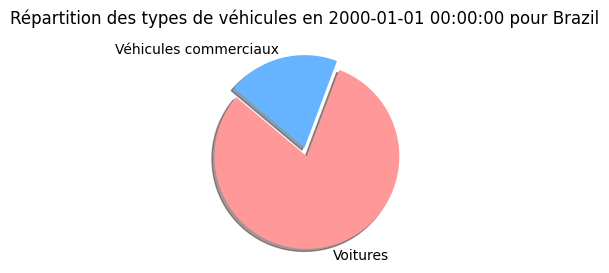

In [25]:
def plot_data(row):
    labels = ['Voitures', 'Véhicules commerciaux']
    sizes = [row['Car_Percentage'], row['Commercial_Vehicle_Percentage']]
    colors = ['#ff9999','#66b3ff']
    explode = (0.1, 0)  # "explode" la première tranche (Voitures)

    # Tracer le camembert
    plt.figure(figsize=(3, 3))
    plt.pie(sizes, explode=explode, labels=labels, colors=colors,
            shadow=True, startangle=140)
    plt.title(f"Répartition des types de véhicules en {row['Year']} pour {row['Country_Name']}")
    plt.show()

def get_place_list(df):
    return df['Country_Name'].unique(), df['Continent'].unique()

def repartition_vehicles(date, place):
    filtered_df = df[df['Year'] == date]
    countries, continents = get_place_list(df=df)

    if place in countries:
        filtered_df = filtered_df[filtered_df['Country_Name'] == place]
    elif place in continents:
        filtered_df = filtered_df[filtered_df['Continent'] == place]

    if filtered_df.empty:
        print("Aucune donnée trouvée pour les critères spécifiés.")
        return

    # Calculer la répartition des types de véhicules
    filtered_df['Car_Percentage'] = (filtered_df['Nbr_Cars'] / filtered_df['Total']) * 100
    filtered_df['Commercial_Vehicle_Percentage'] = (filtered_df['Nbr_Commercial_Vehicle'] / filtered_df['Total']) * 100

    # print(filtered_df)

    # Afficher les résultats
    for index, row in filtered_df.iterrows():
        # print(row)
        print(f"Pour {row['Country_Name']} en {row['Year']}:")
        print(f"  - Pourcentage de voitures : {row['Car_Percentage']:.2f}%")
        print(f"  - Pourcentage de véhicules commerciaux : {row['Commercial_Vehicle_Percentage']:.2f}%\n")
        plot_data(row)

repartition_vehicles("2000-01-01", place="Brazil")
# repartition_vehicles("2020-01-01", place="France")

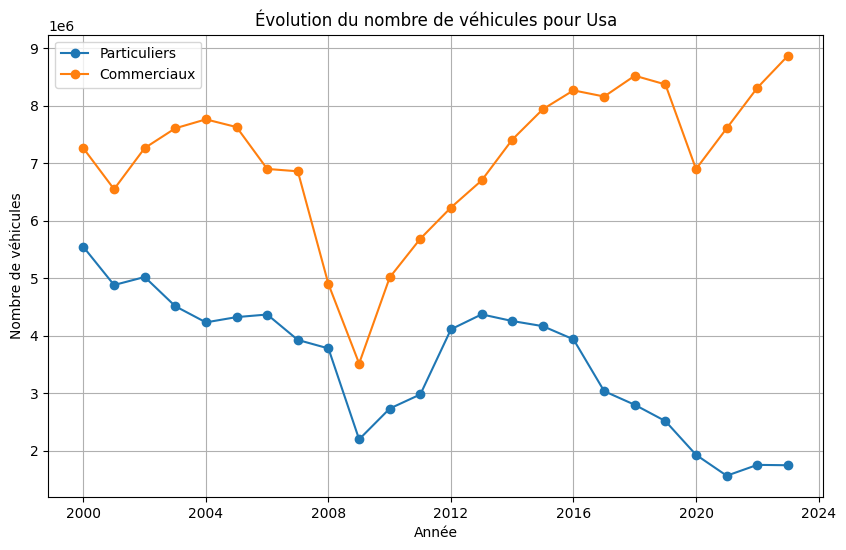

In [27]:
def plot_vehicle_evolution(country=None, continent=None):
    filtered_df = df.copy()

    if country:
        filtered_df = filtered_df[filtered_df['Country_Name'] == country]
    elif continent:
        filtered_df = filtered_df[filtered_df['Continent'] == continent]
        # filtered_df = filtered_df.groupby('Year').agg({
        #             'Nbr_Cars': 'sum',
        #             'Nbr_Commercial_Vehicle': 'sum'
        #         }).reset_index()
    if filtered_df.empty:
        print("Aucune donnée trouvée pour les critères spécifiés.")
        return

    # print(filtered_df)

    plt.figure(figsize=(10, 6))

    plt.plot(filtered_df['Year'], filtered_df['Nbr_Cars'], marker='o', label='Particuliers')
    plt.plot(filtered_df['Year'], filtered_df['Nbr_Commercial_Vehicle'], marker='o', label='Commerciaux')

    plt.xlabel('Année')
    plt.ylabel('Nombre de véhicules')
    plt.title(f"Évolution du nombre de véhicules {'pour ' + country if country else 'en ' + continent}")
    plt.legend()
    plt.grid(True)

    plt.show()

plot_vehicle_evolution(country="Usa")

## Exporter DataFrame nettoyé en CSV

In [28]:
filename_to_save = f'datasets/world_car_production_{begin_year}-{end_year}_cleaned.csv'
df.to_csv(filename_to_save, index=False, sep=';')

PBI : Fichier > Options et paramètres > Options > Fonctionnalités en préversion > Intéractions sur l'objet => ACTIVER

## Prévisions production

In [29]:
df_production = pd.read_csv('datasets/world_car_production_2000-2023_cleaned.csv', sep=';')

In [30]:
df_production.dtypes

Year                      object
Country_Name              object
Nbr_Cars                   int64
Nbr_Commercial_Vehicle     int64
Total                      int64
Percent_Change            object
Continent                 object
dtype: object

In [31]:
df_production['Year'] = pd.to_datetime(df_production['Year'])

In [ ]:
# df_production['Year'] = df_production['Year'].dt.year

In [32]:
df_production.dtypes

Year                      datetime64[ns]
Country_Name                      object
Nbr_Cars                           int64
Nbr_Commercial_Vehicle             int64
Total                              int64
Percent_Change                    object
Continent                         object
dtype: object

In [33]:
len(df_production['Country_Name'].unique())

46

In [34]:
warnings.filterwarnings('ignore')

def sarima_forecast(country_name, data):
    print(country_name)
    """
    This function makes a forecast for a given country using the SARIMA model.

    Args:
        country_name: The name of the country to forecast for.
        data: The Pandas dataframe containing the population data.

    Returns:
        A tuple containing the SARIMA model, the predicted values, and the confidence intervals.
    """
    # Filter the data for the given country.
    df_out = data[data['Country_Name'] == country_name].copy()
    df_out.set_index('Year', inplace=True)

    # print(df_out)

    # Train the SARIMA model.
    model = SARIMAX(df_out['Total'], order=(2, 1, 2), seasonal_order=(1, 0, 1, 12))
    results = model.fit()

    # Make predictions.
    forecast_horizon = 10
    forecast = results.get_forecast(steps=forecast_horizon)
    predictions = forecast.predicted_mean
    conf_int = forecast.conf_int()

    return model, predictions, conf_int, df_out

countries = df_production['Country_Name'].unique()
# countries = ['France']
# countries = ['Afghanistan', 'Africa (UN)', 'Albania', 'Algeria',
#        'American Samoa', 'Andorra', 'Angola']

predictions_list = []

for country in countries:
    # try:
    country_data = df_production[df_production['Country_Name'] == country]
    country_data['Year'] = pd.to_datetime(country_data['Year'], format='%Y')
    # print(country)
    model, predictions, conf_int, df_out = sarima_forecast(country, country_data)
    predictions.index = pd.date_range(start=df_out.index[-1] + pd.offsets.YearEnd(1), periods=10, freq='Y')
    conf_int.index = predictions.index

    # Create a new dataframe with the predictions and confidence intervals
    predictions_df = pd.DataFrame({
        'Country_Name': country,
        'Year': predictions.index,
        'Total': predictions.values,
        'Lower CI': conf_int.iloc[:, 0].values,
        'Upper CI': conf_int.iloc[:, 1].values
    })

    # Add the predictions dataframe to the list
    predictions_list.append(predictions_df)

    # except ValueError as e:
      # print(f"Skipping country {country} due to error: {e}")

df_production_with_all_predictions = pd.concat([df_production] + predictions_list, ignore_index=True)

Argentina
Australia
Austria
Belgium
Brazil
Canada
China
Czechia
Egypt
Finland
France
Germany
Hungary
India
Indonesia
Iran
Italy
Japan
Malaysia
Mexico
Netherlands
Poland
Portugal
Romania
Russia
Serbia
Slovakia
Slovenia
South africa
South korea
Spain
Sweden
Taiwan
Thailand
Turkey
Ukraine
United kingdom
Usa
Uzbekistan
Others
Supplementary
Total
Morocco
Colombia
Czech republic
Kazakhstan


In [35]:
df_production_with_all_predictions[df_production_with_all_predictions['Country_Name'] == 'France']

,Year,Country_Name,Nbr_Cars,Nbr_Commercial_Vehicle,Total,Percent_Change,Continent,Lower CI,Upper CI
10,2000-01-01,France,2879810.0,468551.0,3.348361e+06,5.3%,Europe,NaN,NaN
50,2001-01-01,France,3181549.0,446869.0,3.628418e+06,8.4%,Europe,NaN,NaN
90,2002-01-01,France,3292797.0,309073.0,3.601870e+06,-0.7%,Europe,NaN,NaN
130,2003-01-01,France,3220329.0,399737.0,3.620066e+06,0.5%,Europe,NaN,NaN
170,2004-01-01,France,3227416.0,438574.0,3.665990e+06,1.3%,Europe,NaN,NaN
210,2005-01-01,France,3112961.0,436047.0,3.549008e+06,-3.2%,Europe,NaN,NaN
250,2006-01-01,France,2723196.0,446023.0,3.169219e+06,-10.7%,Europe,NaN,NaN
290,2007-01-01,France,2550869.0,464985.0,3.015854e+06,-4.8%,Europe,NaN,NaN
330,2008-01-01,France,2145935.0,423043.0,2.568978e+06,-14.8%,Europe,NaN,NaN
370,2009-01-01,France,1819497.0,228196.0,2.047693e+06,-20.3%,Europe,NaN,NaN


In [36]:
df_production_with_all_predictions.to_csv('previsions/previsions_world_car_production.csv', index=False)

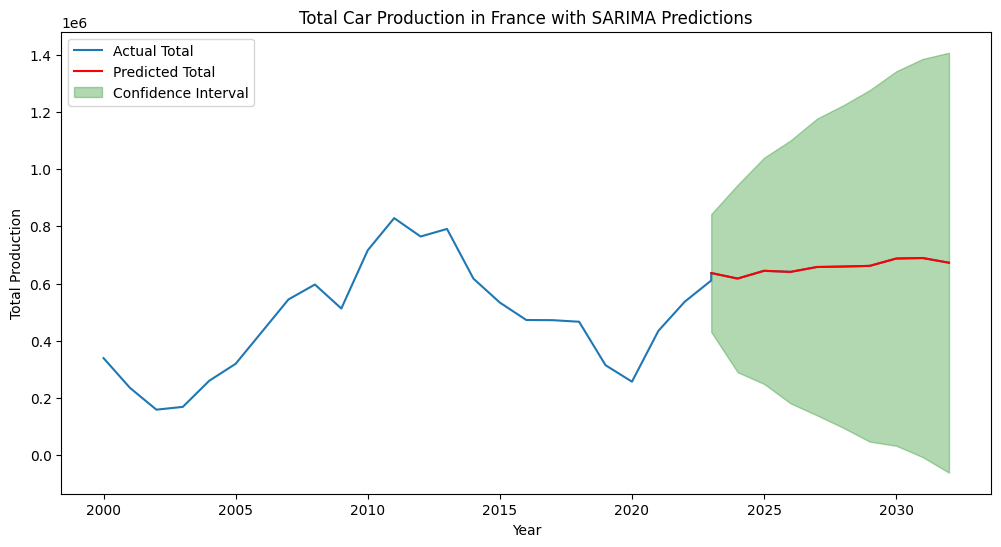

In [37]:
df_production_with_all_predictions['Year'] = pd.to_datetime(df_production_with_all_predictions['Year'], errors='coerce', format="%Y")

df_production_with_all_predictions['Year'] = df_production_with_all_predictions['Year'].dt.year

france_data = df_production_with_all_predictions[df_production_with_all_predictions['Country_Name'] == 'Argentina']

plt.figure(figsize=(12, 6))

plt.plot(france_data['Year'], france_data['Total'], label='Actual Total')

predicted_data = france_data[france_data['Lower CI'].notnull()]
plt.plot(predicted_data['Year'], predicted_data['Total'], label='Predicted Total', color='red')

plt.fill_between(predicted_data['Year'], predicted_data['Lower CI'], predicted_data['Upper CI'], color='green', alpha=0.3, label='Confidence Interval')

plt.title('Total Car Production in France with SARIMA Predictions')
plt.xlabel('Year')
plt.ylabel('Total Production')
plt.legend()
plt.show()

# Evolution des ventes de véhicules

pays, où on a trouvé les données ?

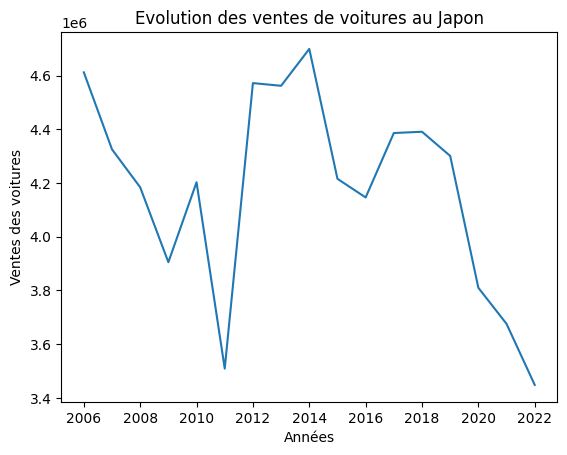

In [38]:
df_car_sales = pd.read_csv('datasets/car_country_sales.csv')

df_car_sales.columns = ['Year', 'Sales', 'Country']

df_car_sales['Sales'] = df_car_sales['Sales'].replace(',', '', regex=True)
df_car_sales['Sales'] = df_car_sales['Sales'].replace('\.', '', regex=True)
df_car_sales['Sales'] = df_car_sales['Sales'].replace(' ', '', regex=True)
df_car_sales['Sales'] = pd.to_numeric(df_car_sales['Sales'])

df_car_sales_japan = df_car_sales[df_car_sales['Country'] == 'Japan']
df_car_sales_usa = df_car_sales[df_car_sales['Country'] == 'US']
df_car_sales_france = df_car_sales[df_car_sales['Country'] == 'France']
df_car_sales_sweden = df_car_sales[df_car_sales['Country'] == 'Sweden']

plt.plot(df_car_sales_japan['Year'], df_car_sales_japan['Sales'])
plt.title('Evolution des ventes de voitures au Japon')
plt.xlabel('Années')
plt.ylabel('Ventes des voitures')
plt.show()

In [39]:
df_car_sales.describe()

,Year,Sales
count,71.000000,7.000000e+01
mean,2013.619718,3.125155e+06
std,5.161302,2.382378e+06
min,2005.000000,2.134080e+05
25%,2009.000000,6.667948e+05
50%,2014.000000,2.259500e+06
75%,2018.000000,4.569820e+06
max,2022.000000,7.762000e+06


In [40]:
df_sales_to_analyze = df_car_sales[['Country', 'Year', 'Sales']]
df_sales_to_analyze.head()

,Country,Year,Sales
0,Japan,2006,4612318.0
1,Japan,2007,4325508.0
2,Japan,2008,4184266.0
3,Japan,2009,3905310.0
4,Japan,2010,4203181.0


In [41]:
import warnings
warnings.filterwarnings('ignore')

def sarima_forecast(country_name, data):
    print(country_name)
    """
    This function makes a forecast for a given country using the SARIMA model.

    Args:
        country_name: The name of the country to forecast for.
        data: The Pandas dataframe containing the population data.

    Returns:
        A tuple containing the SARIMA model, the predicted values, and the confidence intervals.
    """
    # Filter the data for the given country.
    df_out = data[data['Country'] == country_name].copy()
    df_out.set_index('Year', inplace=True)

    # Train the SARIMA model.
    model = SARIMAX(df_out['Sales'], order=(2, 1, 2), seasonal_order=(1, 0, 1, 12))
    results = model.fit()

    # Make predictions.
    forecast_horizon = 10
    forecast = results.get_forecast(steps=forecast_horizon)
    predictions = forecast.predicted_mean
    conf_int = forecast.conf_int()

    return model, predictions, conf_int, df_out

countries = df_sales_to_analyze['Country'].unique()

predictions_list = []

for country in countries:
    try:
      df_sales_to_analyze['Year'] = pd.to_datetime(df_sales_to_analyze['Year'], format='%Y')
      # df_sales_to_analyze.set_index('Year', inplace=True)  # Set 'Year' as index
      model, predictions, conf_int, df_out = sarima_forecast(country, df_sales_to_analyze)
      # start_date = df.index[-1] + pd.offsets.YearBegin(-1)
      # predictions.index = pd.date_range(start=start_date, periods=10, freq='Y')
      predictions.index = pd.date_range(start=df_out.index[-1] + pd.offsets.YearEnd(1), periods=10, freq='Y')
      conf_int.index = predictions.index

      # Create a new dataframe with the predictions and confidence intervals
      predictions_df = pd.DataFrame({
          'Country': country,
          'Year': predictions.index,
          'Sales': predictions.values,
          'Lower CI': conf_int.iloc[:, 0].values,
          'Upper CI': conf_int.iloc[:, 1].values
      })

      # Add the predictions dataframe to the list
      predictions_list.append(predictions_df)

    except ValueError as e:
      print(f"Skipping country {country} due to error: {e}")

df_sales_with_all_predictions = pd.concat([df_sales_to_analyze] + predictions_list, ignore_index=True)

Japan
US
Sweden
France


In [42]:
df_sales_with_all_predictions[df_sales_with_all_predictions['Country'] == 'Sweden']

,Country,Year,Sales,Lower CI,Upper CI
35,Sweden,2005-01-01,274301.000000,NaN,NaN
36,Sweden,2006-01-01,282766.000000,NaN,NaN
37,Sweden,2007-01-01,306799.000000,NaN,NaN
38,Sweden,2008-01-01,253982.000000,NaN,NaN
39,Sweden,2009-01-01,213408.000000,NaN,NaN
40,Sweden,2010-01-01,289684.000000,NaN,NaN
41,Sweden,2011-01-01,304984.000000,NaN,NaN
42,Sweden,2012-01-01,279899.000000,NaN,NaN
43,Sweden,2013-01-01,268599.000000,NaN,NaN
44,Sweden,2014-01-01,303948.000000,NaN,NaN


In [43]:
df_sales_with_all_predictions.to_csv('previsions/previsions_car_sales.csv', index=False)

# Analyses population

## Import

In [44]:
df_population = pd.read_csv('datasets/population_1950_2021.csv')
df_population.head()

,Country name,Year,Population,Population of children under the age of 1,Population of children under the age of 5,Population of children under the age of 15,Population under the age of 25,Population aged 15 to 64 years,Population older than 15 years,Population older than 18 years,...,population__all__50_54__records,population__all__55_59__records,population__all__60_64__records,population__all__65_69__records,population__all__70_74__records,population__all__75_79__records,population__all__80_84__records,population__all__85_89__records,population__all__90_94__records,population__all__95_99__records
0,Afghanistan,1950,7480464,301735.0,1248282,3068855,4494349,4198587,4411609,3946595,...,255563,211607,161196,110709,64310,28381,8153,1346,115,8
1,Afghanistan,1951,7571542,299368.0,1246857,3105444,4552138,4250002,4466098,3993640,...,256915,211966,161821,111465,65210,29148,8672,1483,109,9
2,Afghanistan,1952,7667534,305393.0,1248220,3145070,4613604,4303436,4522464,4041439,...,258952,211946,162710,112142,66123,29903,9137,1584,129,10
3,Afghanistan,1953,7764549,311574.0,1254725,3186382,4676232,4356242,4578167,4088379,...,261238,211731,163777,112800,67058,30647,9561,1693,155,11
4,Afghanistan,1954,7864289,317584.0,1267817,3231060,4741371,4408474,4633229,4136116,...,263301,211816,164736,113474,67953,31345,9963,1830,179,11


Nous créons un nouveau dataframe qui ne prend que les valeurs depuis 1999.

In [45]:
df_pop_99_21 = df_population.query('Year < 1950 or Year > 1998')
df_pop_99_21.head()

,Country name,Year,Population,Population of children under the age of 1,Population of children under the age of 5,Population of children under the age of 15,Population under the age of 25,Population aged 15 to 64 years,Population older than 15 years,Population older than 18 years,...,population__all__50_54__records,population__all__55_59__records,population__all__60_64__records,population__all__65_69__records,population__all__70_74__records,population__all__75_79__records,population__all__80_84__records,population__all__85_89__records,population__all__90_94__records,population__all__95_99__records
49,Afghanistan,1999,19262854,895539.0,4005677,9538093,13136494,9284534,9724752,8519511,...,484402,376737,288028,203661,130178,68573,28101,8086,1462,157
50,Afghanistan,2000,19542986,898809.0,4044487,9716430,13343836,9380030,9826547,8606509,...,479745,381796,289607,205466,132016,70149,28863,8349,1511,163
51,Afghanistan,2001,19688634,894038.0,4046425,9817924,13458009,9420852,9870699,8634748,...,469125,385166,288932,206038,132808,71270,29450,8560,1553,168
52,Afghanistan,2002,21000258,941149.0,4280854,10488288,14365919,10031304,10511959,9179506,...,488363,411182,305420,219365,141488,76759,31864,9300,1699,180
53,Afghanistan,2003,22645136,999679.0,4574403,11313832,15499313,10811842,11331293,9877464,...,517425,441537,327432,236283,152473,83529,34874,10217,1878,197


In [46]:
df_pop_99_21.reset_index(drop=True, inplace=True)

## Prévisions

Conversion de la colonne `Year` en `DateTime`

In [47]:
df_pop_99_21['Year'] = pd.to_datetime(df_pop_99_21['Year'], format='%Y')
df_pop_99_21.head()

,Country name,Year,Population,Population of children under the age of 1,Population of children under the age of 5,Population of children under the age of 15,Population under the age of 25,Population aged 15 to 64 years,Population older than 15 years,Population older than 18 years,...,population__all__50_54__records,population__all__55_59__records,population__all__60_64__records,population__all__65_69__records,population__all__70_74__records,population__all__75_79__records,population__all__80_84__records,population__all__85_89__records,population__all__90_94__records,population__all__95_99__records
0,Afghanistan,1999-01-01,19262854,895539.0,4005677,9538093,13136494,9284534,9724752,8519511,...,484402,376737,288028,203661,130178,68573,28101,8086,1462,157
1,Afghanistan,2000-01-01,19542986,898809.0,4044487,9716430,13343836,9380030,9826547,8606509,...,479745,381796,289607,205466,132016,70149,28863,8349,1511,163
2,Afghanistan,2001-01-01,19688634,894038.0,4046425,9817924,13458009,9420852,9870699,8634748,...,469125,385166,288932,206038,132808,71270,29450,8560,1553,168
3,Afghanistan,2002-01-01,21000258,941149.0,4280854,10488288,14365919,10031304,10511959,9179506,...,488363,411182,305420,219365,141488,76759,31864,9300,1699,180
4,Afghanistan,2003-01-01,22645136,999679.0,4574403,11313832,15499313,10811842,11331293,9877464,...,517425,441537,327432,236283,152473,83529,34874,10217,1878,197


Nous ne nous interessons qu'à trois colonne pour cette analyse globale :

* `Country name`
* `Year`
* `Population`

Pour la prévision, il va falloir créer un dataframe par pays contenant seulement ces trois colonne

In [48]:
df_pop_to_analyze = df_pop_99_21[['Country name', 'Year', 'Population']]
df_pop_to_analyze.head()

,Country name,Year,Population
0,Afghanistan,1999-01-01,19262854
1,Afghanistan,2000-01-01,19542986
2,Afghanistan,2001-01-01,19688634
3,Afghanistan,2002-01-01,21000258
4,Afghanistan,2003-01-01,22645136


Voici un exemple de la courbe de tendance d'évolution de la population, pour un pays donné

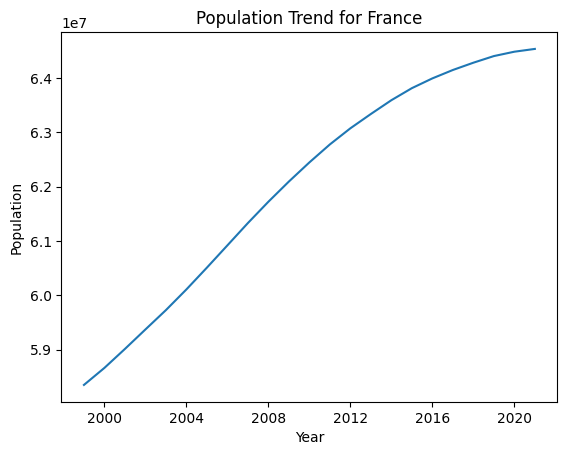

,Country name,Year,Population
1725,France,1999-01-01,58352210
1726,France,2000-01-01,58665456
1727,France,2001-01-01,59014776
1728,France,2002-01-01,59372784
1729,France,2003-01-01,59728260
1730,France,2004-01-01,60108436
1731,France,2005-01-01,60510080
1732,France,2006-01-01,60919150
1733,France,2007-01-01,61329380
1734,France,2008-01-01,61721004


In [49]:
def get_country_data(data, country_name):
    """
    This function takes a country name and returns the rows of the dataframe corresponding to that country.

    Args:
        df_to_analyze: The Pandas dataframe to analyze.
        country_name: The name of the country to filter by.

    Returns:
        A Pandas dataframe containing the data for the specified country.
    """
    data = data[data['Country name'] == country_name]
    plt.plot(data['Year'], data['Population'])
    plt.title(f'Population Trend for {country_name}')
    plt.xlabel('Year')
    plt.ylabel('Population')
    plt.show()

    return data[data['Country name'] == country_name]

country_data = get_country_data(df_pop_to_analyze, 'France')
country_data

Afghanistan
Africa (UN)
Albania
Algeria
American Samoa
Andorra
Angola
Anguilla
Antigua and Barbuda
Argentina
Armenia
Skipping country Armenia due to error: LU decomposition error.
Aruba
Asia (UN)
Australia
Austria
Azerbaijan
Bahamas
Bahrain
Bangladesh
Barbados
Belarus
Belgium
Skipping country Belgium due to error: LU decomposition error.
Belize
Benin
Bermuda
Bhutan
Bolivia
Bonaire Sint Eustatius and Saba
Bosnia and Herzegovina
Botswana
Brazil
Skipping country Brazil due to error: LU decomposition error.
British Virgin Islands
Brunei
Bulgaria
Burkina Faso
Burundi
Skipping country Burundi due to error: LU decomposition error.
Cambodia
Skipping country Cambodia due to error: LU decomposition error.
Cameroon
Canada
Cape Verde
Cayman Islands
Central African Republic
Chad
Chile
China
Colombia
Skipping country Colombia due to error: LU decomposition error.
Comoros
Congo
Cook Islands
Costa Rica
Cote d'Ivoire
Croatia
Cuba
Curacao
Cyprus
Czechia
Democratic Republic of Congo
Denmark
Djibouti
Domi

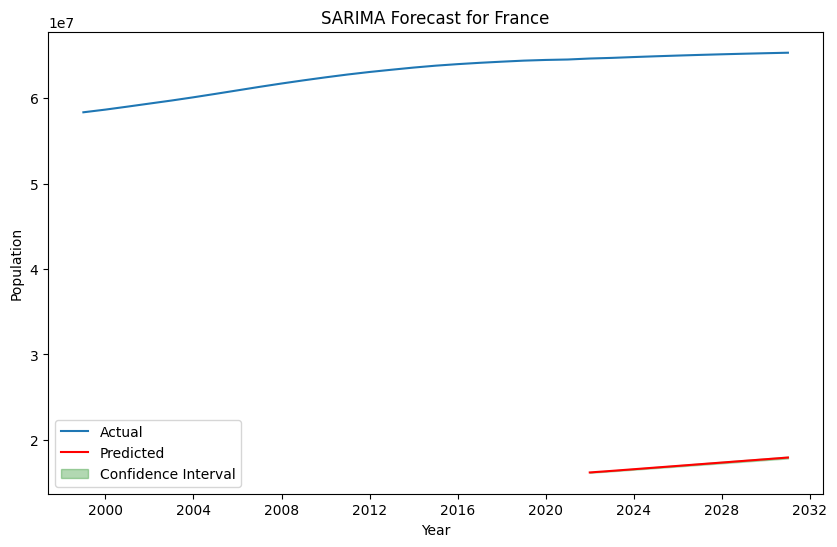

,Country name,Year,Population,Lower CI,Upper CI
0,Afghanistan,1999-01-01,1.926285e+07,NaN,NaN
1,Afghanistan,2000-01-01,1.954299e+07,NaN,NaN
2,Afghanistan,2001-01-01,1.968863e+07,NaN,NaN
3,Afghanistan,2002-01-01,2.100026e+07,NaN,NaN
4,Afghanistan,2003-01-01,2.264514e+07,NaN,NaN
...,...,...,...,...,...
8157,Zimbabwe,2026-12-31,1.715302e+07,1.707486e+07,1.723119e+07
8158,Zimbabwe,2027-12-31,1.734672e+07,1.726181e+07,1.743163e+07
8159,Zimbabwe,2028-12-31,1.754344e+07,1.745215e+07,1.763473e+07
8160,Zimbabwe,2029-12-31,1.773711e+07,1.763974e+07,1.783448e+07


In [50]:
import warnings
warnings.filterwarnings('ignore')

def sarima_forecast(country_name, data):
    print(country_name)
    """
    This function makes a forecast for a given country using the SARIMA model.

    Args:
        country_name: The name of the country to forecast for.
        data: The Pandas dataframe containing the population data.

    Returns:
        A tuple containing the SARIMA model, the predicted values, and the confidence intervals.
    """
    df_out = data[data['Country name'] == country_name].copy()
    df_out.set_index('Year', inplace=True)

    model = SARIMAX(df_out['Population'], order=(2, 1, 2), seasonal_order=(1, 0, 1, 12))
    results = model.fit()

    forecast_horizon = 10
    forecast = results.get_forecast(steps=forecast_horizon)
    predictions = forecast.predicted_mean
    conf_int = forecast.conf_int()

    return model, predictions, conf_int, df_out

countries = df_pop_to_analyze['Country name'].unique()

predictions_list = []

for country in countries:
    try:
      model, predictions, conf_int, df_out = sarima_forecast(country, df_pop_to_analyze)
      predictions.index = pd.date_range(start=df_out.index[-1] + pd.offsets.YearEnd(1), periods=10, freq='Y')
      conf_int.index = predictions.index

      predictions_df = pd.DataFrame({
          'Country name': country,
          'Year': predictions.index,
          'Population': predictions.values,
          'Lower CI': conf_int.iloc[:, 0].values,
          'Upper CI': conf_int.iloc[:, 1].values
      })

      predictions_list.append(predictions_df)

    except ValueError as e:
      print(f"Skipping country {country} due to error: {e}")

df_with_all_predictions = pd.concat([df_pop_to_analyze] + predictions_list, ignore_index=True)

country_name = 'France'
country_data = df_with_all_predictions[df_with_all_predictions['Country name'] == country_name]

plt.figure(figsize=(10, 6))
plt.plot(country_data['Year'], country_data['Population'], label='Actual')
plt.plot(predictions.index, predictions, label='Predicted', color='red')
plt.fill_between(predictions.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='green', alpha=0.3, label='Confidence Interval')
plt.title(f'SARIMA Forecast for {country_name}')
plt.xlabel('Year')
plt.ylabel('Population')
plt.legend()
plt.show()

df_with_all_predictions

`conf_int` représente l'intervalle de confiance des prévisions

In [51]:
conf_int

,lower Population,upper Population
2021-12-31,1.615634e+07,1.621832e+07
2022-12-31,1.632806e+07,1.641622e+07
2023-12-31,1.651158e+07,1.662021e+07
2024-12-31,1.669954e+07,1.682572e+07
2025-12-31,1.688538e+07,1.702728e+07
2026-12-31,1.707486e+07,1.723119e+07
2027-12-31,1.726181e+07,1.743163e+07
2028-12-31,1.745215e+07,1.763473e+07
2029-12-31,1.763974e+07,1.783448e+07
2030-12-31,1.783056e+07,1.803695e+07


Voici les données pour la France, de 1999 jusqu'aux prévisions, en 2030

In [52]:
df_with_all_predictions[df_with_all_predictions['Country name'] == 'France']

,Country name,Year,Population,Lower CI,Upper CI
1725,France,1999-01-01,5.835221e+07,NaN,NaN
1726,France,2000-01-01,5.866546e+07,NaN,NaN
1727,France,2001-01-01,5.901478e+07,NaN,NaN
1728,France,2002-01-01,5.937278e+07,NaN,NaN
1729,France,2003-01-01,5.972826e+07,NaN,NaN
1730,France,2004-01-01,6.010844e+07,NaN,NaN
1731,France,2005-01-01,6.051008e+07,NaN,NaN
1732,France,2006-01-01,6.091915e+07,NaN,NaN
1733,France,2007-01-01,6.132938e+07,NaN,NaN
1734,France,2008-01-01,6.172100e+07,NaN,NaN


### Graphique de prévisions pour un pays donné

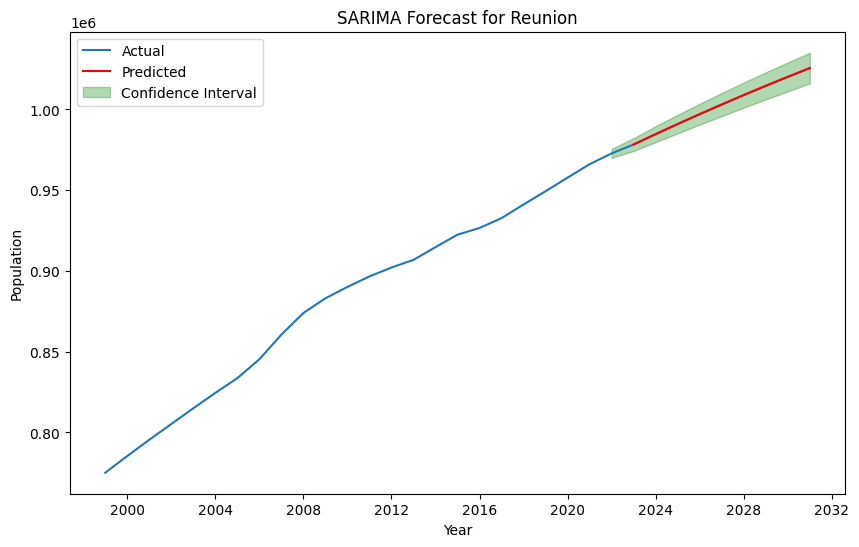

In [53]:
country_name = 'Reunion'

country_data = df_with_all_predictions[df_with_all_predictions['Country name'] == country_name]

plt.figure(figsize=(10, 6))
plt.plot(country_data['Year'], country_data['Population'], label='Actual')
plt.plot(country_data.Year[country_data.Year.dt.year > 2021], country_data.Population[country_data.Year.dt.year > 2021], label='Predicted', color='red')

plt.fill_between(country_data.Year, country_data['Lower CI'], country_data['Upper CI'], color='green', alpha=0.3, label='Confidence Interval')

plt.title(f'SARIMA Forecast for {country_name}')
plt.xlabel('Year')
plt.ylabel('Population')
plt.legend()

plt.show()

### Export des prévisions

In [54]:
df_with_all_predictions.to_csv('previsions/previsions_population_1999_2021.csv', index=False)